In [2]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import math
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution
from qwak.qwak import QWAK
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


In [3]:
def modify_marked_prob_list(marked_prob_list):
    modified_list = []
    for sublist in marked_prob_list:
        new_sublist = sublist.copy()

        max_idx = new_sublist.index(max(new_sublist))
        min_found = False
        last_min_value = None

        for idx, elem in enumerate(new_sublist[max_idx:]):
            if idx + max_idx > 0 and new_sublist[idx + max_idx - 1] > elem:
                min_found = True
                last_min_value = elem
            if min_found and new_sublist[idx + max_idx - 1] < elem:
                new_sublist[idx + max_idx:] = [last_min_value] * len(new_sublist[idx + max_idx:])
                break

        modified_list.append(new_sublist)
    return modified_list

def smooth_matrices(matrix1, matrix2, matrix3, sigma=1):
    """
    Applies 2D Gaussian smoothing to three input matrices.
    
    Parameters:
        matrix1 (numpy array): first input matrix
        matrix2 (numpy array): second input matrix
        matrix3 (numpy array): third input matrix
        sigma (float): standard deviation of the Gaussian filter
    
    Returns:
        tuple: a tuple of three smoothed matrices
    """
    smoothed_matrix1 = gaussian_filter(matrix1, sigma=sigma)
    smoothed_matrix2 = gaussian_filter(matrix2, sigma=sigma)
    smoothed_matrix3 = gaussian_filter(matrix3, sigma=sigma)
    
    return (smoothed_matrix1, smoothed_matrix2, smoothed_matrix3)

def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def plotSearch(N,probT,tSpace,configVec):
    plotName = ""
    for T,walk,config,n in zip(tSpace,probT,configVec,N):
        #print(config)
        plt.plot(T,walk,color=config[0],linestyle=config[1],label="N=%s"%n)
        plt.vlines(max(T),0,1,color=config[0],linestyle=config[2])
        plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for n in N:
        plotName+='_'+str(n)
    plt.savefig(r"C:\Users\jaime\Documents\GitHub\QWAK\Notebook\Output\\"+f"Search{plotName}")
    # plt.clf()
    
def gamma_hypercube(n):
    total = 0
    for r in range(1, n + 1):
        binomial_coefficient = math.comb(n, r)
        total += binomial_coefficient * (1 / r)
    return ((1 / (2 ** n)) * total)/2

0.7392917736281377


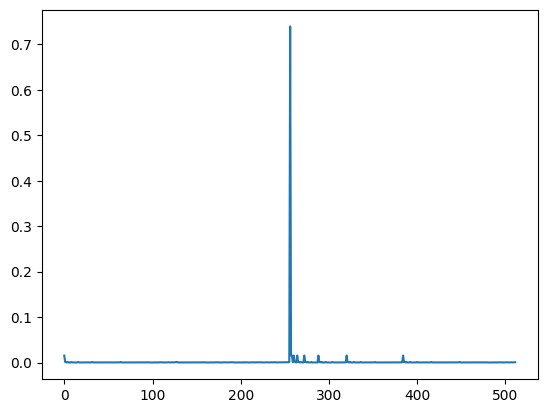

In [4]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n) # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N))
# t = 43
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
print(max(qw.getProbVec()))
plt.plot(qw.getProbVec())


In [17]:
def plot_search(markedList, probT, tSpace, configVec, gamma_range, x_num_ticks=5, y_num_ticks=5, x_round_val=3, y_round_val=3, filepath=None,
                xlabel='Number of steps', ylabel='Probability of marked elements', cbar_label='Gamma', font_size=12, figsize=(8, 6),
                cbar_num_ticks=None, cbar_tick_labels=None, plot_title='Hypercube Search'):

    fig, ax = plt.subplots(figsize=figsize)

    max_prob = 0
    max_prob_t = 0

    for T, walk, config, marked in zip(tSpace, probT, configVec, markedList):
        ax.plot(T, walk, color=config[0], linestyle=config[1])
        ax.set_xlabel(xlabel, fontsize=font_size + 2)
        ax.set_ylabel(ylabel, fontsize=font_size + 2)
        ax.set_title(plot_title, fontsize=font_size+4)

        cur_max_prob = np.max(walk)
        if cur_max_prob > max_prob:
            max_prob = cur_max_prob
            max_prob_t = T[np.argmax(walk)]

    ax.tick_params(axis='both', which='major', labelsize=font_size)

    num_t_ticks = min(y_num_ticks, len(tSpace[0]))
    t_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_t_ticks), y_round_val)

    ax.set_yticks(np.linspace(0, max_prob, num_t_ticks))
    ax.set_yticklabels(np.round(np.linspace(0, max_prob, num_t_ticks), y_round_val))

    num_x_ticks = min(x_num_ticks, len(tSpace[0]))
    x_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks), x_round_val)

    ax.set_xticks(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks))
    ax.set_xticklabels(x_tick_labels)

    colors = [config[0] for config in configVec]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
    norm = BoundaryNorm(gamma_range, len(gamma_range)-1)

    if cbar_num_ticks is not None:
        cbar_ticks = np.linspace(gamma_range[0], gamma_range[-1], cbar_num_ticks)
    else:
        cbar_ticks = None

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=cbar_ticks)
    cbar.set_label(cbar_label, fontsize=font_size + 2)
    cbar.ax.tick_params(labelsize=font_size)

    if cbar_tick_labels is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)

    ax.axvline(max_prob_t, color='black', linestyle='dashed', linewidth=1.5,
               ymax=max_prob/ax.get_ylim()[1])
    # ax.text(max_prob_t + 0.5, max_prob + 0.05, f'Max Prob = {max_prob:.{y_round_val}f}', fontsize=font_size)

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
    else:
        plt.show()


def multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond):
    markedProbList = []
    markedElementsMatrix = []
    timeMatrix = []
    probDistList = []
    markedProbMatrix = []
    sampleCounter = 1
    for gamma in gammaList:
        qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
        print(f'GAMMA {round(gamma, 4)}/{max(gammaList)} \t Sample {sampleCounter}/{len(gammaList)}')
        sampleCounter += 1
        for time in timeList:
            qw.runWalk(time=time,initStateList=initCond)
            probDistList.append(copy.deepcopy(qw.getProbDist()))
        markedProbList = searchProbStepsPlotting2(qw,probDistList)
        markedProbMatrix.append(markedProbList)
        probDistList = []
        markedElementsMatrix.append(markedElements)
        timeMatrix.append( timeList)
    return markedProbMatrix,markedElementsMatrix,timeMatrix

In [18]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n)
gammaMin = gamma/1.10

N = len(graph)
t =  (np.pi/(2) * np.sqrt(N))
maxTime = 2.2*t

print(f'N = {N}')
print(f'GammaMin = {gammaMin}')
print(f'T = {t}')

initCond = list(range(0,len(graph)))

samples = 200
timeList = np.linspace(0,maxTime,samples)
print(max(timeList))
gammaList =  np.linspace(gammaMin,gamma ,samples).tolist()
markedElements = [(N//2,-1)]

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
configVec = list(zip(colors,lines))

N = 512
GammaMin = 0.11725760675955989
T = 35.54306350526693
78.19473971158725


In [19]:
time_file = f'Datasets/HypercubeSearch/timeMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
markedElements_file = f'Datasets/HypercubeSearch/markedElementsMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
marked_prob_file = f'Datasets/HypercubeSearch/markedProbMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'

if os.path.exists(time_file) and os.path.exists(markedElements_file) and os.path.exists(marked_prob_file):
    markedProbMatrix = load_nested_list_from_file(marked_prob_file)
    markedElementsMatrix = load_nested_list_from_file(markedElements_file)
    timeMatrix = load_nested_list_from_file(time_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    markedProbMatrix,markedElementsMatrix,timeMatrix = multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond)
    if not os.path.exists(markedElements_file):
        write_nested_list_to_file(markedElements_file, markedProbMatrix)
    if not os.path.exists(time_file):
        write_nested_list_to_file(time_file, timeMatrix)
    if not os.path.exists(marked_prob_file):
        write_nested_list_to_file(marked_prob_file, markedProbMatrix)

File exists!


[array([0.5, 0. , 1. , 1. ]), array([0.49215686, 0.01231966, 0.99998103, 1.        ]), array([0.48431373, 0.02463745, 0.99992411, 1.        ]), array([0.47647059, 0.0369515 , 0.99982925, 1.        ]), array([0.46078431, 0.06156091, 0.99952572, 1.        ]), array([0.45294118, 0.07385253, 0.99931706, 1.        ]), array([0.44509804, 0.08613294, 0.99907048, 1.        ]), array([0.42941176, 0.11065268, 0.9984636 , 1.        ]), array([0.42156863, 0.12288829, 0.99810333, 1.        ]), array([0.41372549, 0.13510525, 0.99770518, 1.        ]), array([0.40588235, 0.1473017 , 0.99726917, 1.        ]), array([0.39019608, 0.17162568, 0.99628365, 1.        ]), array([0.38235294, 0.18374952, 0.99573418, 1.        ]), array([0.3745098 , 0.19584547, 0.99514692, 1.        ]), array([0.35882353, 0.21994636, 0.99385914, 1.        ]), array([0.35098039, 0.23194764, 0.99315867, 1.        ]), array([0.34313725, 0.24391372, 0.99242051, 1.        ]), array([0.33529412, 0.25584278, 0.9916447 , 1.        ]), a

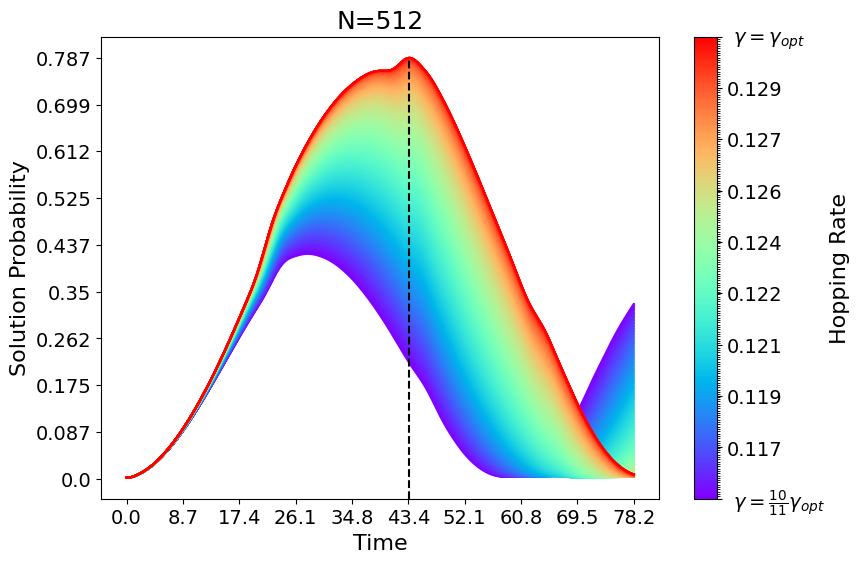

In [20]:
gamma_range=gammaList
x_num_ticks=10
y_num_ticks=10
x_round_val=1
y_round_val=3

filepath=f'Output/HypercubeSearch/hypercubePlot_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.png'

plot_title = f'N={N}'

xlabel='Time'
ylabel='Solution Probability'
cbar_label='Hopping Rate'

font_size=14
figsize=(9, 6)

cbar_num_ticks=10

cbar_tick_labels=[r' $\gamma = \frac{10}{11}\gamma_{opt}$'] + [f'{round(x,3)}' for x in np.linspace(gammaMin,gamma ,cbar_num_ticks-2).tolist()] + [r' $\gamma = \gamma_{opt}$']

plot_search(markedList=markedElementsMatrix, probT=markedProbMatrix, tSpace=timeMatrix, configVec=configVec,
            gamma_range=gamma_range,x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, x_round_val=x_round_val, y_round_val=y_round_val, 
            filepath=filepath,xlabel=xlabel, ylabel=ylabel, cbar_label=cbar_label, font_size=font_size, 
            figsize=figsize,cbar_num_ticks=cbar_num_ticks, cbar_tick_labels=cbar_tick_labels,plot_title=plot_title)

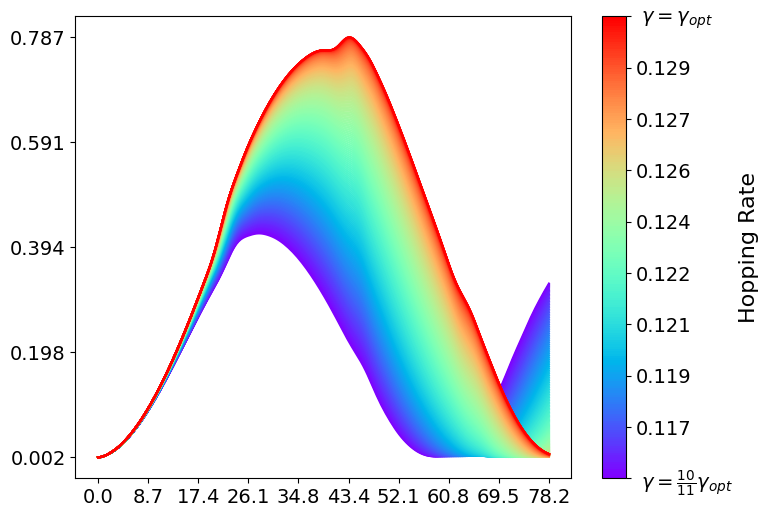

In [32]:
from matplotlib.colors import Normalize

class CustomNorm(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False, ticks=None):
        self.ticks = ticks
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if self.ticks is None:
            return 0
        else:
            return np.interp(value, self.ticks, np.linspace(0, 1, len(self.ticks)))

def plot_data(x_value_matrix, y_value_matrix, x_label=None, y_label=None, title=None, legend_labels=None, legend_title = None, 
              legend_ncol = 3, 
              legend_loc='best',
              save_path=None, font_size=12, figsize=(10,6), color_list=None, line_style_list=None,
              use_loglog=False, use_cbar=False, cbar_label=None, cbar_ticks_generator=None, cbar_num_ticks = 3, cbar_tick_labels=['a','b','c'],
              x_num_ticks=None, y_num_ticks=None, x_round_val=3, y_round_val=3,v_line_values=None, v_line_style= '--', **kwargs):
    
    # Unpack optional parameters
    x_label = kwargs.get('x_label', x_label)
    y_label = kwargs.get('y_label', y_label)
    title = kwargs.get('title', title)
    legend_labels = kwargs.get('legend_labels', legend_labels)
    legend_title = kwargs.get('legend_title', legend_title)
    legend_ncol = kwargs.get('legend_ncol', legend_ncol)
    legend_loc = kwargs.get('legend_loc', legend_loc)
    save_path = kwargs.get('save_path', save_path)
    font_size = kwargs.get('font_size', font_size)
    figsize = kwargs.get('figsize', figsize)
    color_list = kwargs.get('color_list', color_list)
    line_style_list = kwargs.get('line_style_list', line_style_list)
    use_loglog = kwargs.get('use_loglog', use_loglog)
    use_cbar = kwargs.get('use_cbar', use_cbar)
    cbar_label = kwargs.get('cbar_label', cbar_label)
    cbar_ticks_generator = kwargs.get('cbar_ticks', cbar_ticks_generator)
    cbar_num_ticks = kwargs.get('cbar_num_ticks', cbar_num_ticks)
    cbar_tick_labels = kwargs.get('cbar_tick_labels', cbar_tick_labels)
    x_num_ticks = kwargs.get('x_num_ticks', x_num_ticks)
    y_num_ticks = kwargs.get('y_num_ticks', y_num_ticks)
    x_round_val = kwargs.get('x_round_val', x_round_val)
    y_round_val = kwargs.get('y_round_val', y_round_val)
    v_line_values = kwargs.get('v_line_values', v_line_values)
    v_line_style = kwargs.get('v_line_style', v_line_style)
    
    # plot the data for each row of the data matrix
    fig, ax = plt.subplots(figsize=figsize)
    if use_loglog:
        ax.loglog()
    # ax.set_xlim([x_values[0], x_values[-1]])
    i = 0
    for xvalues,yvalues in zip(x_value_matrix,y_value_matrix):
        color = None
        line_style = None
        label = None
        if color_list is not None:
            color = color_list[i]
        if line_style_list is not None:
            line_style = line_style_list[i]
        if legend_labels is not None:
            label = legend_labels[i]
        ax.plot(xvalues, yvalues, label=label,
                color=color, linestyle=line_style)
        if v_line_values is not None:
            ax.axvline(x = v_line_values[i][0],ymin = 0, ymax = v_line_values[i][1]/ax.get_ylim()[1] , color=color, linestyle=v_line_style, linewidth=1.5)
        i+=1

    # set the axis labels
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=font_size+2)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=font_size+2)

    # set the plot title
    if title is not None:
        ax.set_title(title, fontsize=font_size+4)

    # set the legend
    if legend_labels is not None:
        legend = ax.legend(loc=legend_loc,ncol=legend_ncol, fontsize=font_size-1)
        if legend_title is not None:
            legend.set_title(legend_title, prop={'size': font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=font_size)
    
    min_x_value_matrix = np.min(x_value_matrix)
    max_x_value_matrix = np.max(x_value_matrix)
    
    min_y_value_matrix = np.min(y_value_matrix)
    max_y_value_matrix = np.max(y_value_matrix)
    # set tick labels
    if x_num_ticks is not None:
        num_x_ticks = min(x_num_ticks, len(x_value_matrix[0]))
        x_tick_labels = np.round(np.linspace(min_x_value_matrix, max_x_value_matrix, num_x_ticks), x_round_val)
        ax.set_xticks(np.linspace(min_x_value_matrix, max_x_value_matrix, num_x_ticks))
        ax.set_xticklabels(x_tick_labels)
    
    if y_num_ticks is not None:
        num_y_ticks = min(y_num_ticks, len(y_value_matrix[1]))
        y_tick_labels = np.round(np.linspace(min_y_value_matrix, max_y_value_matrix, num_y_ticks), y_round_val)
        ax.set_yticks(np.linspace(min_y_value_matrix, max_y_value_matrix, num_y_ticks))
        ax.set_yticklabels(y_tick_labels)

    # add colorbar
    if use_cbar:
        if cbar_ticks_generator is None:
            cbar_ticks = np.linspace(min_y_value_matrix, max_y_value_matrix, cbar_num_ticks)
        else:
            cbar_ticks = cbar_ticks_generator
        colors = color_list
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
        # norm = BoundaryNorm(cbar_ticks, len(cbar_ticks)-1)
        norm = Normalize(vmin=cbar_ticks[0], vmax=cbar_ticks[-1])
        
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=cbar_ticks)
        if cbar_label is not None:
            cbar.set_label(cbar_label, fontsize=font_size + 2)
        cbar.ax.tick_params(labelsize=font_size)

    if cbar_tick_labels is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()
        
color_list = plt.cm.rainbow(np.linspace(0, 1, len(gamma_range)))
    
params = {
    'font_size' : 14,
    'figsize': (8, 6),
    'plot_title' : f'N={N}',
    'xlabel' : 'Time',
    'ylabel' : 'Solution Probability',
    'legend_ncol' : 1,
    'color_list' : color_list,
    'filepath' : f'Output/HypercubeSearch/hypercubePlot_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.png',
    'use_loglog': False,
    'use_cbar' : True,
    'cbar_label' : 'Hopping Rate', 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_num_ticks' : 10,
    'y_num_ticks' : 5,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'cbar_ticks_generator': gamma_range,
     'cbar_tick_labels': [r' $\gamma = \frac{10}{11}\gamma_{opt}$'] + [f'{round(x,3)}' for x in np.linspace(gammaMin,gamma ,cbar_num_ticks-2).tolist()] + [r' $\gamma = \gamma_{opt}$'],
    'cbar_num_ticks' : 10
    
}


plot_data(x_value_matrix = timeMatrix, y_value_matrix = markedElementsMatrix,**params)